In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image


ModuleNotFoundError: No module named 'torch'

In [2]:
# Define activations separately for indexing and instantiation
activation_names = ['sigmoid', 'tanh', 'relu', 'elu', 'selu', 'swish']
activation_map = {
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'relu': nn.ReLU,
    'elu': nn.ELU,
    'selu': nn.SELU,
    'swish': lambda: nn.SiLU(),  # swish ≈ SiLU in PyTorch
}

def decode_action(action_id):
    if 0 <= action_id <= 41:  # Dense Layer with some number of units
        units_list = [8, 16, 32, 64, 128, 256, 512]
        units_idx = action_id // len(activation_names)
        act_idx = action_id % len(activation_names)
        units = units_list[units_idx]
        activation_name = activation_names[act_idx]
        activation_fn = activation_map[activation_name]
        return ('dense', units, activation_name)  

    elif 42 <= action_id <= 44:  # Dropout layer
        dropout_rates = [0.0, 0.2, 0.5]
        return ('dropout', dropout_rates[action_id - 42])

    elif action_id == 45:  # BatchNorm layer
        return ('batchnorm',)

    elif action_id == 46:  # Stop building layers
        return ('stop',)

    else:
        raise ValueError(f"Invalid action id: {action_id}")


In [16]:
class NASMLPEnv(Env):
    def __init__(self, dataset, max_layers=10, render_mode=None):
        
        #new
        super().__init__()
        self.render_mode = render_mode
        
        self.dataset = dataset  
        self.max_layers = max_layers
        self.action_space = Discrete(47)
        self.observation_space = Box(low=0, high=1, shape=((max_layers + 10) * 3,), dtype=np.float32)  # 3 inputs per layer, layer type, number of units, and activation function
        self.architecture = []
        self.done = False

        self.best_architecture = None
        self.best_reward = -float('inf')

        self.architecture_log = []

        self.max_parameters = self._estimate_max_parameters()

    #NEW    
    def render(self, mode= "rgb_array"):
        import matplotlib.pyplot as plt
        import numpy as np
        from io import BytesIO
        from PIL import Image
        import matplotlib.patches as patches

        if mode == "rgb_array":

            fig, ax = plt.subplots(figsize=(max(5, len(self.architecture) * 2), 3))
            ax.axis("off")

            # Draw all layers at once
            spacing = 2
            box_width = 1.5
            box_height = 1.2

            for i, layer in enumerate(self.architecture):
                x = i * spacing
                y = 0.5

                layer_type = layer[0]
                params = layer[1:] if len(layer) > 1 else []

                # Build label
                if layer_type == "dense":
                    label = f"Dense\n{params[0]} units" if params else "Dense"
                elif layer_type == "conv":
                    label = f"Conv\n{params[0]}x{params[1]}" if len(params) >= 2 else "Conv"
                elif layer_type == "dropout":
                    label = f"Dropout\n{params[0]}" if params else "Dropout"
                elif layer_type == "stop":
                    label = "STOP"
                else:
                    label = layer_type.capitalize()

                # Draw box
                rect = patches.FancyBboxPatch(
                    (x, y),
                    box_width,
                    box_height,
                    boxstyle="round,pad=0.02",
                    edgecolor="black",
                    facecolor="#add8e6"
                )
                ax.add_patch(rect)

                # Add label centered in box
                ax.text(
                    x + box_width / 2,
                    y + box_height / 2,
                    label,
                    ha="center",
                    va="center",
                    fontsize=10
                )

                # Connect with arrows
                if i < len(self.architecture) - 1:
                    ax.annotate(
                        "",
                        xy=(x + box_width, y + box_height / 2),
                        xytext=(x + spacing, y + box_height / 2),
                        arrowprops=dict(arrowstyle="->", lw=1.5)
                    )

            # Adjust plot limits
            ax.set_xlim(-1, len(self.architecture) * spacing)
            ax.set_ylim(0, 3)

            # Convert to image
            buf = BytesIO()
            plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
            plt.close(fig)
            buf.seek(0)
            img = Image.open(buf).convert("RGB")
            img = img.resize((800, 400))

            return np.array(img)
        else:
            raise NotImplementedError(f"Render mode '{mode}' not supported.")

    
    def reset(self, *, seed=None, options=None):
        if not self.done and self.architecture:
            self.architecture_log.append({
                'architecture': list(self.architecture),
                'reward': 0,
                'accuracy': None,
                'complexity': None,
                'complexity_epochs': None,
                'completed': False,
                'termination_reason': 'incomplete'
            })
        self.architecture = []
        self.done = False
        return self._get_obs(), {}

    def _estimate_max_parameters(self):
        input_dim = self.dataset[0].shape[1]  
        max_units = 512
        total_params = 0
    
        for _ in range(self.max_layers):
            total_params += input_dim * max_units + max_units  
            input_dim = max_units
    
        output_dim = self.dataset[1].shape[1]
        total_params += max_units * output_dim + output_dim
    
        return total_params


    def step(self, action_id):
        decoded = decode_action(action_id)
        truncated = False
        
        if len(self.architecture) == 0 and decoded[0] == 'stop':
            return self._get_obs(), -100.0, False, truncated, {}

        dense_count = sum(1 for layer in self.architecture if layer[0] == 'dense')
        if decoded[0] == 'stop' or (decoded[0] == 'dense' and dense_count >= self.max_layers):
            terminated = True
            reward, acc, complexity, complexity_epochs = self._evaluate_model()  

            # Log architecture, reward, accuracy, and complexity
            self.architecture_log.append({
                'architecture': list(self.architecture),
                'reward': reward,
                'accuracy': acc,
                'complexity': complexity,
                'complexity_epochs': complexity_epochs,
                'completed': True,
                'termination_reason': 'stop' if decoded[0] == 'stop' else 'max_dense'
            })

    
            print(f"\n🎯 Final Architecture: {self.architecture}")
            print(f"🏆 Validation Accuracy (acc): {acc:.2f}%")
            print(f"⚙️  Complexity (number of layers): {complexity}")
            print(f"🏅 Reward (acc - penalty): {reward:.2f}%\n")
            print(f"🏅 Complexity (Number of epochs): {complexity_epochs:.2f}%\n")
            
            # Track best
            if reward > self.best_reward:
                self.best_reward = reward
                self.best_architecture = list(self.architecture)
                self.best_accuracy = acc  
                self.best_complexity = complexity 
                print(f"🌟 New Best Architecture Found with Reward: {reward:.2f}%")
            reward = acc
        else:
            self.architecture.append(decoded)
            reward = 0
            terminated = False
            
        truncated = False

        return self._get_obs(), reward, terminated, truncated, {}
        #return self._get_obs(), reward, self.done, {}


    def _get_obs(self):
        obs = np.zeros(self.observation_space.shape[0])
        for i, layer in enumerate(self.architecture):
            base = i * 3
            if layer[0] == 'dense':
                obs[base] = layer[1] / 512  # normalized units
                obs[base + 1] = activation_names.index(layer[2]) / (len(activation_names) - 1)
                obs[base + 2] = 0
            elif layer[0] == 'dropout':
                obs[base] = layer[1]
                obs[base + 1] = -1
                obs[base + 2] = 1
            elif layer[0] == 'batchnorm':
                obs[base] = -1
                obs[base + 1] = -1
                obs[base + 2] = 2
        return obs

    def _evaluate_model(self):
        X_train, y_train, X_val, y_val = self.dataset

        model = nn.Sequential()
        input_dim = X_train.shape[1]

        for i, layer in enumerate(self.architecture):
            if layer[0] == 'dense':
                model.add_module(f"fc{i}", nn.Linear(input_dim, layer[1]))
                model.add_module(f"act{i}", activation_map[layer[2]]())
                input_dim = layer[1]
            elif layer[0] == 'dropout':
                model.add_module(f"dropout{i}", nn.Dropout(p=layer[1]))
            elif layer[0] == 'batchnorm':
                model.add_module(f"bn{i}", nn.BatchNorm1d(input_dim))

        model.add_module("output", nn.Linear(input_dim, y_train.shape[1]))

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01) # can make the RL choose optimizer and LR also here
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

        best_acc = 0
        patience = 3
        patience_counter = 0
        max_epochs = 100
        epochs_used = 0
        model.train()
        for _ in range(10):  
            for xb, yb in train_loader:
                optimizer.zero_grad()
                output = model(xb)
                loss = loss_fn(output, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        for _ in range(max_epochs):  
            for xb, yb in train_loader:
                optimizer.zero_grad()
                output = model(xb)
                loss = loss_fn(output, yb)
                loss.backward()
                optimizer.step()
    
            # Early stopping check
            model.eval()
            with torch.no_grad():
                preds = model(X_val)
                acc = (preds.argmax(dim=1) == y_val.argmax(dim=1)).float().mean().item()
    
            epochs_used += 1
    
            if acc > best_acc + 1e-4:
                best_acc = acc
                patience_counter = 0
            else:
                patience_counter += 1
    
            if patience_counter >= patience:
                break

        no_of_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        max_params = self._estimate_max_parameters()
        epochs_percentage = epochs_used*100/max_epochs
        alpha = 0.8
        #beta = 0.1

        reward = (alpha * acc * 100) + ((1 - alpha) * (100 - (no_of_params * epochs_used)/(max_params * max_epochs)))
        #reward = (alpha * acc * 100) + ((1 - alpha - beta) * (100 - (no_of_params*100/max_params))) + (beta * (100 - epochs_percentage))

        return reward, acc * 100, 100 - (no_of_params*100/max_params), (100 - epochs_percentage)

In [17]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.nn.functional import one_hot

import openml
dataset = openml.datasets.get_dataset(23512)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

df = pd.concat([X, y], axis=1)

df.dropna(inplace=True)

X = df.drop(columns=[dataset.default_target_attribute])
y = df[dataset.default_target_attribute]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)  

y_oh = one_hot(torch.tensor(y_encoded).long()).float()

X_train_np, X_val_np, y_train_tensor, y_val_tensor = train_test_split(
    X_scaled, y_oh, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train_np).float()
X_val_tensor = torch.tensor(X_val_np).float()

In [18]:
dataset = (X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

In [19]:
print(X_train_tensor.shape)  # [n_train, n_features]
print(y_train_tensor.shape)  # [n_train, 2]  (one-hot binary)

torch.Size([88244, 28])
torch.Size([88244, 2])


In [34]:
# Pass into your NAS environment
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import imageio_ffmpeg
import moviepy
from imageio.v2 import imread
import os
from moviepy.editor import ImageSequenceClip
import numpy as np


# 1. Create base env
def make_env():
    env = NASMLPEnv(dataset=dataset, max_layers=10, render_mode="rgb_array")
    env.render_mode = "rgb_array"  # Ensure it's explicitly set for VecVideoRecorder
    return env

# 2. Wrap in DummyVecEnv (SB3 expects vectorized envs)
env = DummyVecEnv([make_env])

env.envs[0].render_mode = "rgb_array"
env.render_mode = "rgb_array"


# 3. Video output dir
video_dir = "./videos/"
os.makedirs(video_dir, exist_ok=True)

# 4. Wrap with VecVideoRecorder (no render_mode here!)
env = VecVideoRecorder(
    env,
    video_folder=video_dir,
    record_video_trigger=lambda step: step % 1000 == 0,
    video_length=1000,
    name_prefix="dqn-nas"
)

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import DQN

import time

start_time = time.time()

model = DQN(
    "MlpPolicy",
    env,
    gamma=0.99,                       
    exploration_initial_eps=1.0,     
    exploration_final_eps=0.05,      
    exploration_fraction=0.1,        
    verbose=1,
    tensorboard_log="./nas_logs/"
)


eval_callback = EvalCallback(env, best_model_save_path="./nas_agent_checkpoint_alpha_0.8_23513/",
                             log_path="./nas_logs/", eval_freq=1000,
                             deterministic=True, render=False)

#model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./nas_logs/")
model.learn(total_timesteps=10000, callback=eval_callback)

env.close()

end_time = time.time()
elapsed_time = end_time - start_time

Using cpu device
Logging to ./nas_logs/DQN_53

🎯 Final Architecture: [('dense', 16, 'relu'), ('dense', 16, 'elu'), ('dropout', 0.2), ('dense', 256, 'relu'), ('dropout', 0.2), ('dense', 512, 'sigmoid'), ('dense', 32, 'elu')]
🏆 Validation Accuracy (acc): 65.94%
⚙️  Complexity (number of layers): 93.56435768378395
🏅 Reward (acc - penalty): 72.75%

🏅 Complexity (Number of epochs): 95.00%

🌟 New Best Architecture Found with Reward: 72.75%

🎯 Final Architecture: [('dense', 16, 'selu'), ('dense', 64, 'elu'), ('dense', 256, 'relu'), ('dense', 32, 'tanh'), ('dense', 512, 'selu'), ('dense', 16, 'swish'), ('dense', 256, 'sigmoid'), ('dense', 256, 'tanh'), ('dense', 128, 'tanh'), ('dense', 128, 'swish')]
🏆 Validation Accuracy (acc): 53.32%
⚙️  Complexity (number of layers): 92.80058896249986
🏅 Reward (acc - penalty): 62.66%

🏅 Complexity (Number of epochs): 96.00%


🎯 Final Architecture: [('dense', 8, 'relu'), ('dense', 512, 'sigmoid'), ('dense', 64, 'tanh'), ('dense', 32, 'tanh'), ('dense', 128, 

t:   0%|          | 2/401 [5:38:23<1125:08:02, 10151.59s/it, now=None]

Saving video to C:\Users\derek\School\Classes\Math M148\videos\dqn-nas-step-0-to-step-1000.mp4
Moviepy - Building video C:\Users\derek\School\Classes\Math M148\videos\dqn-nas-step-0-to-step-1000.mp4.


t:   0%|          | 2/401 [5:38:23<1125:08:38, 10151.68s/it, now=None]

Moviepy - Writing video C:\Users\derek\School\Classes\Math M148\videos\dqn-nas-step-0-to-step-1000.mp4




t:   0%|          | 2/401 [5:39:24<1128:32:49, 10182.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready C:\Users\derek\School\Classes\Math M148\videos\dqn-nas-step-0-to-step-1000.mp4

🎯 Final Architecture: [('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu')]
🏆 Validation Accuracy (acc): 53.32%
⚙️  Complexity (number of layers): 93.5885616221345
🏅 Reward (acc - penalty): 62.66%

🏅 Complexity (Number of epochs): 95.00%


🎯 Final Architecture: [('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu'), ('dense', 128, 'elu')]
🏆 Validation Accuracy (acc): 46.68%
⚙️  Complexity (number of layers): 93.5885616221345
🏅 Reward (acc - penalty): 57.34%

🏅 Complexity (Number of epochs): 96.00%


🎯 Final Architecture: [('dense', 128, 'elu'), (

In [17]:
model.save("nas_agent_checkpoint_alpha_0.8_23512")

In [ ]:
# load previous model
# model = DQN.load("nas_agent_checkpoint")

In [ ]:
# analyze the results

In [26]:
print(elapsed_time)

42909.503651857376


In [30]:
print(env.envs[0].best_architecture)

[('dense', 64, 'sigmoid'), ('dense', 64, 'sigmoid'), ('dense', 64, 'sigmoid')]


In [31]:
print(f"\n Best Reward: {env.envs[0].best_reward:.2f}%")


 Best Reward: 78.03%


In [32]:
print(f"\n Best Accuracy: {env.envs[0].best_accuracy:.2f}%")


 Best Accuracy: 72.53%


In [33]:
print(f"\n Best Accuracy: {env.envs[0].best_complexity:.2f}%")


 Best Accuracy: 99.57%


In [35]:
# Analyzing the different combinations
import pandas as pd

flat_data = []
for run in env.architecture_log:
    has_dropout = any(layer[0] == 'dropout' for layer in run['architecture'])
    has_batchnorm = any(layer[0] == 'batchnorm' for layer in run['architecture'])

    for layer in run['architecture']:
        if layer[0] == 'dense':
            flat_data.append({
                'units': layer[1],
                'activation': layer[2],
                'dropout': has_dropout,
                'batchnorm': has_batchnorm,
                'reward': run['reward']
            })
df = pd.DataFrame(flat_data)
df.to_csv("architecture_analysis.csv", index=False)

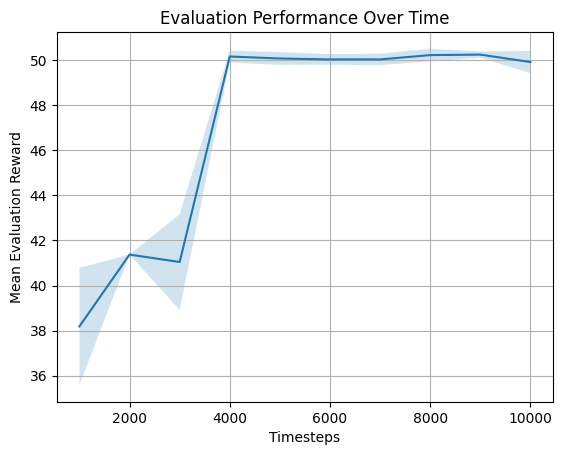

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npz file (binary format)
data = np.load("./nas_logs/evaluations.npz")

# Extract data
timesteps = data["timesteps"]
results = data["results"]  # shape: (evals, n_envs)
ep_lengths = data["ep_lengths"]  # optional

# Plot mean evaluation reward
plt.plot(timesteps, results.mean(axis=1))
plt.fill_between(timesteps,
                 results.mean(axis=1) - results.std(axis=1),
                 results.mean(axis=1) + results.std(axis=1),
                 alpha=0.2)
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Reward")
plt.title("Evaluation Performance Over Time")
plt.grid(True)
plt.show()

# This will give you a clean visualization of your agent’s evaluation performance (e.g., every 1000 steps) 
# and confidence intervals (standard deviation) across environments.


In [128]:
from moviepy.editor import ImageSequenceClip
import numpy as np
from PIL import Image


# Reload env with render access (not Vec)
env = DummyVecEnv([make_env]) # This gives you the base NASNetEnv, not DummyVecEnv
obs = env.reset()
frames = []
PAUSE_FRAMES = 5  # Adjust this to control pause duration
n_steps = 50      # Or however many architecture steps you want

for _ in range(n_steps):
    # Use the trained model or random actions
    action, _ = model.predict(obs)
    oobs, rewards, dones, infos = env.step(action)
    
    # Render the full architecture at this step
    frame = env.envs[0].render(mode="rgb_array")
    frames.append(frame.copy())
    
    if terminated or truncated:
        break

# Create a video from all the frames
clip = ImageSequenceClip(frames, fps=2)  # Adjust fps as desired
clip.write_videofile("architecture_evolution.mp4")

    
#frame = env.render(mode="rgb_array")
#img = Image.fromarray(frame)
#img.save("final_architecture.png")

# Create and save video
#clip = ImageSequenceClip(frames, fps=10)
#clip.write_videofile("architecture_demo.mp4")


🎯 Final Architecture: [('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu')]
🏆 Validation Accuracy (acc): 53.32%
⚙️  Complexity (number of layers): 25.215209149761026
🏅 Reward (acc - penalty): 45.47%

🌟 New Best Architecture Found with Reward: 45.47%

🎯 Final Architecture: [('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 512, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu')]
🏆 Validation Accuracy (acc): 53.32%
⚙️  Complexity (number of layers): 30.73370709368689
🏅 Reward (acc - penalty): 44.91%


🎯 Final Architecture: [('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense', 256, 'relu'), ('dense

Moviepy - Done !
Moviepy - video ready architecture_evolution.mp4


In [ ]:
env = DummyVecEnv([make_env])  # Your NASNetEnv wrapped
obs = env.reset()
n_steps = 50  # Set how many steps to run

# Folder to store frames
os.makedirs("architecture_images", exist_ok=True)

for step in range(n_steps):
    # Get action (random or from a model)
    action, _ = model.predict(obs)
    obs, rewards, dones, infos = env.step(action)
    
    # Render the architecture
    frame = env.envs[0].render(mode="rgb_array")  # Returns numpy array

    # Save the image
    img = Image.fromarray(frame)
    img.save(f"architecture_images/step_{step:03}.png")

    # Optional early stop
    if dones[0]:  # or: if terminated or truncated depending on API
        break

In [ ]:
tensorboard --logdir=nas_logs --port=6006

|   n_layers |   accuracy |   complexity |   reward |
|-----------:|-----------:|-------------:|---------:|
|          2 |    72.361  |     0.258259 |  65.0991 |
|          2 |    72.1979 |     0.258259 |  64.9522 |
|          2 |    72.1775 |     0.258259 |  64.9339 |
|          2 |    72.1673 |     0.258259 |  64.9247 |
|          2 |    72.1571 |     0.258259 |  64.9155 |


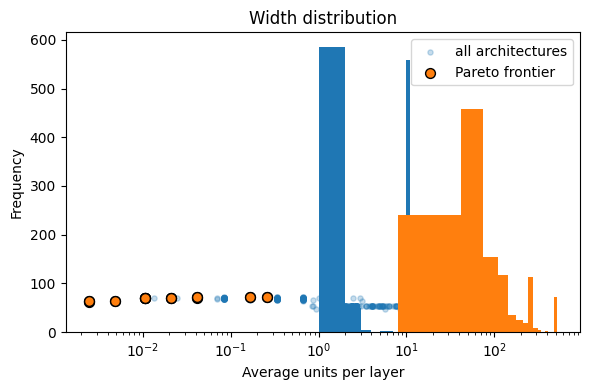

In [10]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv('architecture_analysis_updated_alpha_0.9.csv')


# -- roll up to one row per architecture -----------------------------
arch = (
    df.groupby('arch_id')
      .agg(
          n_layers     = ('layer_num', 'max'),     # depth
          accuracy     = ('accuracy', 'first'),    # same on every layer row
          complexity   = ('complexity', 'first'),  # "
          reward       = ('reward', 'first')       # "
      )
      .reset_index()
)


# Pareto frontier 
front = (
    arch.sort_values('complexity')
        .assign(cum_acc=lambda x: x['accuracy'].cummax())
        .query('accuracy == cum_acc')
)

plt.figure(figsize=(6,4))
plt.scatter(arch['complexity'], arch['accuracy'],
            s=14, alpha=.25, label='all architectures')
plt.scatter(front['complexity'], front['accuracy'],
            s=50, edgecolors='k', label='Pareto frontier')
plt.xscale('log')                       # avoid x-axis pile-up
plt.xlabel('Parameters (log scale)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy–Size Trade-off (α = 0.9)')
plt.legend()
plt.tight_layout()
plt.savefig('./pareto_alpha09.png', dpi=120)


# Depth histogram
arch['n_layers'].plot.hist(bins=range(1, arch['n_layers'].max()+2))
plt.xlabel('Layers'); plt.title('Depth distribution')
plt.tight_layout(); plt.savefig('./depth_hist.png')

# optional: average layer width
width = (df.groupby('arch_id')['units'].mean().rename('avg_units')
         .to_frame().join(arch.set_index('arch_id')))
width['avg_units'].plot.hist(bins=15)
plt.xlabel('Average units per layer'); plt.title('Width distribution')
plt.tight_layout(); plt.savefig('./width_hist.png')


# Top-5 architectures
top5 = arch.sort_values('reward', ascending=False).head(5)
print(top5[['n_layers','accuracy','complexity','reward']].to_markdown(index=False))



In [9]:
%pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
